In [1]:
import sys

In [2]:
import torch

In [3]:
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoModel, AutoTokenizer 

In [4]:
import os

In [5]:
import pandas as pd

In [6]:
import dask.dataframe as dd

In [7]:
import numpy as np

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import string

In [10]:
import torch.nn.functional as F

# Load Data

In [11]:
examples_path = os.path.join('.', 'data', 'shopping_queries_dataset_examples.parquet')
products_path = os.path.join('.', 'data', 'shopping_queries_dataset_products.parquet')
sources_path = os.path.join('.', 'data', 'shopping_queries_dataset_sources.csv')

examples = dd.read_parquet(examples_path)
products = dd.read_parquet(products_path)
sources = dd.read_csv(sources_path)

In [12]:
examples_products = dd.merge(
    examples,
    products,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)

examples_products = examples_products[examples_products['product_locale'] == 'us']

task_2 = examples_products[examples_products['large_version'] == 1]

# removing puncuation 
# this takes in the dask data frame and the string puncuation 
# applied to the daskdata frame
# lambda which processes each test in the dask series 
# it iterates through each character and saves only characters that are not in puncts
puncts = string.punctuation
def process_text(text_series, puncts):
    return text_series.apply(lambda text: ''.join(ch for ch in str(text) if ch not in puncts))


task_2['query'] = task_2['query'].map_partitions(process_text, puncts=puncts)


# encoding the esci labels 
label_mapping = {'E': 0, 
                 'S': 1, 
                 'C': 2, 
                 'I': 3}

task_2['encoded_labels'] = task_2['esci_label'].map(label_mapping).astype(int)



task_2_train = task_2[task_2['split'] == 'train']
task_2_test = task_2[task_2['split'] == 'test']

/home/cgcordes/python3.14/lib/python3.11/site-packages/dask_expr/_collection.py:4196: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('esci_label', 'float64'))

  warnings.warn(meta_warning(meta))


In [13]:
# Sample data for proof of concept 
# delete later 
data = {'query': ["!qscreen fence without holes", "#1 black natural hair dye without ammonia or peroxide", 
                  "$100 things that are not electronics", "%100 silicone not clear", "&#34;tortillas without interesterified soybean oilâ€"]}

# create the fake data frame 
df = dd.from_pandas(pd.DataFrame(data), npartitions=1)

# applying to the 'query' column using map_partitions
df['query'] = df['query'].map_partitions(process_text, puncts=puncts)

pd.set_option('display.max_colwidth', None)

print(df.compute())

                                                  query
0                           qscreen fence without holes
1  1 black natural hair dye without ammonia or peroxide
2                   100 things that are not electronics
3                                100 silicone not clear
4    34tortillas without interesterified soybean oilâ€


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Sampling for imbalance 

In [15]:
# counting the ammount of C labels in the large data set 
task_2_train_C = task_2_train[task_2_train['encoded_labels'] == 2]
print(task_2_train_C.compute().shape)

(29127, 15)


In [16]:
# randomly sampling the same number for exact matches 
# working on the exact samples
task_2_train_E = task_2_train[task_2_train['encoded_labels'] == 0]
total_rows_E = task_2_train_E.shape[0].compute()
sample_fraction = 29127 / total_rows_E
task_2_train_sample_E = task_2_train_E.sample(frac=sample_fraction, random_state=42)

print(task_2_train_sample_E.compute().shape)

/home/cgcordes/python3.14/lib/python3.11/site-packages/dask/core.py:133: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  return func(*(_execute_task(a, cache) for a in args))


(29127, 15)


In [17]:
task_2_train_S = task_2_train[task_2_train['encoded_labels'] == 1]
total_rows_S = task_2_train_S.shape[0].compute()
sample_fraction = 29127 / total_rows_S
task_2_train_sample_S = task_2_train_S.sample(frac=sample_fraction, random_state=42)
print(task_2_train_sample_S.compute().shape)


/home/cgcordes/python3.14/lib/python3.11/site-packages/dask/core.py:133: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  return func(*(_execute_task(a, cache) for a in args))


(29127, 15)


In [18]:
task_2_train_I = task_2_train[task_2_train['encoded_labels'] == 3]
total_rows_I = task_2_train_I.shape[0].compute()
sample_fraction = 29127 / total_rows_I
task_2_train_sample_I = task_2_train_I.sample(frac=sample_fraction, random_state=42)
print(task_2_train_sample_I.compute().shape)

/home/cgcordes/python3.14/lib/python3.11/site-packages/dask/core.py:133: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  return func(*(_execute_task(a, cache) for a in args))


(29127, 15)


In [19]:
# combining the data frame 
balanced_train = dd.concat([task_2_train_C, task_2_train_sample_E, task_2_train_sample_S, task_2_train_sample_I], axis=0, ignore_unknown_divisions=True)
balanced_train = balanced_train.repartition(npartitions=1)
print(balanced_train.compute().shape)

(116508, 15)


In [20]:
# repartition so it behave as a single dataset 
print(balanced_train.compute().head())

     example_id                                                 query  \
22           22                           awnmower tires without rims   
143         222                               2 pencils not sharpened   
286         365  1 best and not expensive bath back brush cream color   
320         399  1 best and not expensive bath back brush cream color   
811         890             2 pencils with erasers sharpened not soft   

     query_id  product_id product_locale esci_label  small_version  \
22          1  B01M3SJ699             us          C              1   
143         6  B075DTDGSS             us          C              1   
286        11  B07HGH25S3             us          C              1   
320        11  B01K8PEZMU             us          C              1   
811        28  B01FWSJQU4             us          C              1   

     large_version  split  \
22               1  train   
143              1  train   
286              1  train   
320              1  trai

# Defining the model

In [14]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
model = AutoModel.from_pretrained('distilroberta-base').to(device)

for param in model.parameters():
    param.requires_grad = False

def generate_embeddings(texts):
    batch_size = 128  # adjust this size
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

def process_partition(partition):
    query_embeddings = generate_embeddings(partition['query'])
    product_title_embeddings = generate_embeddings(partition['product_title'])

    combined = torch.cat((torch.tensor(query_embeddings), torch.tensor(product_title_embeddings)), dim=1).numpy()
    
    print(f'Combined shape: {combined.shape}')  # Expecting (n, 1536)

    result = pd.DataFrame(combined, index=partition.index, columns=[f'embedding_{i}' for i in range(combined.shape[1])])

    return result

In [15]:
# creating a data frame and enerate column names
meta = pd.DataFrame(columns=[f'embedding_{i}' for i in range(2 * 768)], dtype='float64')

In [16]:
def generate_embeddings(texts):
    batch_size = 128  # adjust this size
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        # change for maxpooling (dim=1)
        pooled_embeddings = torch.max(outputs.last_hidden_state, dim=1).values
        batch_embeddings = pooled_embeddings.cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

def process_partition(partition):
    query_embeddings = generate_embeddings(partition['query'])
    product_title_embeddings = generate_embeddings(partition['product_title'])

    combined = torch.cat((torch.tensor(query_embeddings), torch.tensor(product_title_embeddings)), dim=1).numpy()
    
    print(f'Combined shape: {combined.shape}')  # Expecting (n, 1536)

    result = pd.DataFrame(combined, index=partition.index, columns=[f'embedding_{i}' for i in range(combined.shape[1])])

    return result


# Sampling the Data (Ignore when looking at full set) 

In [14]:
# computes the total number of rows in the df
total_rows = task_2_train.shape[0].compute()

# calculates the fraction of rows needed to sample 10000 
sample_fraction = 10000 / total_rows

# samples a fraction of the df 
task_2_train_sample = task_2_train.sample(frac=sample_fraction, random_state=42)

In [16]:
# replicating the same as above but with the test data 
# computes the total number of rows in the df
total_rows2 = task_2_test.shape[0].compute()

# calculates the fraction of rows needed to sample 
sample_fraction2 = 10000 / total_rows2

# samples a fraction of the df 
task_2_test_sample = task_2_test.sample(frac=sample_fraction2, random_state=42)

# Computing the Embeddings (Ignore after reading to CSV/NUMPY) 

In [19]:
# Computing the Embeddings for Train Data 
result = task_2_train.map_partitions(process_partition, meta=meta)
result = result.compute()

Combined shape: (1393063, 1536)


In [42]:
# Read it to a CSV 
result.to_csv('result_train_distilroberta_nopunct.csv')

In [24]:
# Read it to a NUMPY 
result_array = result.to_numpy()
np.save('result_train_distilroberta.npy', result_array)

In [20]:
# Computing the Embeddings for the Test Data
result2 = task_2_test.map_partitions(process_partition, meta=meta)
result2 = result2.compute()

Combined shape: (425762, 1536)


In [43]:
# Read it to a CSV 
result2.to_csv('result_test_distilroberta_nopunct.csv')

In [19]:
# Read it to a NUMPY 
result2_array = result2.to_numpy()
np.save('result_test_distilroberta.npy', result2_array)

In [ ]:
# rename if redoing the embeddings 
result = result_train
result2 = result_test

# Importing Embeddings and Checking Structure 

In [17]:
# Read in the pre-saved data 
# This will take a little bit 
result_train = pd.read_csv('result_train_distilroberta_nopunct.csv', index_col=0)
result_test = pd.read_csv('result_test_distilroberta_nopunct.csv', index_col=0)

In [22]:
print(result_train.head())

   embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0      0.12433     0.127676     0.085034     0.039097     0.297458   
1      0.12433     0.127676     0.085034     0.039097     0.297458   
2      0.12433     0.127676     0.085034     0.039097     0.297458   
3      0.12433     0.127676     0.085034     0.039097     0.297458   
4      0.12433     0.127676     0.085034     0.039097     0.297458   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  ...  \
0     0.201057     0.026599     0.275267     0.080479     0.023758  ...   
1     0.201057     0.026599     0.275267     0.080479     0.023758  ...   
2     0.201057     0.026599     0.275267     0.080479     0.023758  ...   
3     0.201057     0.026599     0.275267     0.080479     0.023758  ...   
4     0.201057     0.026599     0.275267     0.080479     0.023758  ...   

   embedding_1526  embedding_1527  embedding_1528  embedding_1529  \
0        0.419537        0.067311        0.201484        0.

In [23]:
print(result_test.head())

    embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
32    -0.010883     0.190984     0.055915    -0.007884     0.761822   
33    -0.010883     0.190984     0.055915    -0.007884     0.761822   
34    -0.010883     0.190984     0.055915    -0.007884     0.761822   
35    -0.010883     0.190984     0.055915    -0.007884     0.761822   
36    -0.010883     0.190984     0.055915    -0.007884     0.761822   

    embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  ...  \
32    -0.056676     0.139391     0.148942     0.076152     0.198935  ...   
33    -0.056676     0.139391     0.148942     0.076152     0.198935  ...   
34    -0.056676     0.139391     0.148942     0.076152     0.198935  ...   
35    -0.056676     0.139391     0.148942     0.076152     0.198935  ...   
36    -0.056676     0.139391     0.148942     0.076152     0.198935  ...   

    embedding_1526  embedding_1527  embedding_1528  embedding_1529  \
32        0.324944        0.216839        0.45

In [ ]:
# Read it in as a numpy array 
# result = np.load('result_train_distilroberta.npy')
# result2 = np.load('result_test_distilroberta.npy')

In [41]:
# Converting from DASK to Pandas 
task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

In [42]:
# this should all be the same: pandas.core.frame.DataFrame
print(type(task_2_train))
print(type(task_2_test))
print(type(result_train))
print(type(result_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


# Creating the Multi-Layer Preceptron Model

In [43]:
# mlp with maxpooling 
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        # flatten the input 
        x = torch.flatten(x, 1) 
        x = self.fc1(x)
        x = self.relu(x)
        x = x.unsqueeze(1)
        x = self.pool(x)  
        # flatten the pooled output 
        x = x.view(x.size(0), -1) 
        # apply the 10% dropout 
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [44]:
# Inputting the Parameters

# Size of the concatenated embeddings(768 + 768)
input_size = 1536  
hidden_size = 128
# number of classes Exact, Substitute, Complement, Irrelevant (4)
num_classes = 4 

# initialize the model, loss, and optimizer
model = MLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()

# for the training hyperparameter configuration 
# Adam Optimizer with parameters: epsilon (1e-8), learning rate (5e-5) and weight decay (0.01)
optimizer = optim.Adam(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01)


# Data Loading 

## Labeling Indicies

In [45]:
task_2_train_indices = task_2_train.index.astype(int)
subset_labels = task_2_train['encoded_labels']
subset_labels = subset_labels.to_frame()

In [46]:
task_2_test_indices = task_2_test.index.astype(int)
subset_labels2 = task_2_test['encoded_labels']
subset_labels2 = subset_labels2.to_frame()

In [47]:
# not needed if not sampling 
result_train = result_train.sort_index()
result_test = result_test.sort_index()

In [31]:
# checking the training labels 
print(subset_labels)

         encoded_labels
0                     3
1                     0
2                     0
3                     0
4                     0
...                 ...
1818820               3
1818821               0
1818822               0
1818823               3
1818824               0

[1393063 rows x 1 columns]


In [32]:
# checking the test labels 
print(subset_labels2)

         encoded_labels
32                    3
33                    3
34                    0
35                    1
36                    1
...                 ...
1818788               0
1818789               3
1818790               3
1818791               3
1818792               0

[425762 rows x 1 columns]


In [48]:
class ESCIDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings.values
        # this should be (size, 1563)
        print("Shape of embeddings:", self.embeddings.shape)
        self.labels = labels   

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# create DataLoader
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # adjust the batch size as needed 

Shape of embeddings: (1393063, 1536)


In [49]:
# making the test loader 
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (425762, 1536)


In [50]:
# these should be the same length 
print("Length of embeddings:", len(train_dataset.embeddings))
print("Length of labels:", len(train_dataset.labels))

Length of embeddings: 1393063
Length of labels: 1393063


In [51]:
# these should both be 'numpy.ndarray' or theres a problem 
print("Type of embeddings:", type(train_dataset.embeddings))
print("Type of labels:", type(train_dataset.labels))

Type of embeddings: <class 'numpy.ndarray'>
Type of labels: <class 'numpy.ndarray'>


In [52]:
# look at the samples to double check everything is looking right 
for i in range(5):  
    embedding, label = train_dataset[i]
    print(f"sample {i} - embedding: {embedding}, label: {label}")

sample 0 - embedding: [0.12432991 0.12767594 0.0850341  ... 0.33728772 0.21012834 0.26508397], label: 3
sample 1 - embedding: [0.12432991 0.12767594 0.0850341  ... 0.48584455 0.24631253 0.19101998], label: 0
sample 2 - embedding: [0.12432991 0.12767594 0.0850341  ... 0.47372347 0.21870442 0.20419931], label: 0
sample 3 - embedding: [0.12432991 0.12767594 0.0850341  ... 0.61399883 0.32040575 0.19349714], label: 0
sample 4 - embedding: [0.12432991 0.12767594 0.0850341  ... 0.2160977  0.32783297 0.24916403], label: 0


In [53]:
# training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=4):
    model.train()  # set model to training mode
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (embeddings, labels) in enumerate(train_loader):
            embeddings, labels = embeddings.to(device), labels.to(device)

            optimizer.zero_grad()  
            outputs = model(embeddings.float()) 
            # converting the labels to long 
            labels = labels.long()
            # calculate the loss 
            loss = criterion(outputs, labels) 
            # backpropogation 
            loss.backward() 
            # updating the weights 
            optimizer.step()  

            # add up the loss 
            epoch_loss += loss.item()  

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)


Epoch 1/4, Loss: 0.8373
Epoch 2/4, Loss: 0.8317
Epoch 3/4, Loss: 0.8309
Epoch 4/4, Loss: 0.8309


In [54]:
# evaluation and output the f1 score 
def evaluate_model(test_loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # needed to change this to floats 
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # evaluate on the f1 score with micro averages
    return f1_score(all_labels, all_preds, average='micro')

In [55]:
# evaluating the model
f1 = evaluate_model(test_loader, model)
print(f'micro F1 Score: {f1:.4f}')

micro F1 Score: 0.6514


# Finding Mismatches

In [56]:
def evaluate_and_capture_mismatches(test_loader, model, task_2_test):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # convert task_2_test to pandas df if it's a dask df
    if hasattr(task_2_test, 'compute'):
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']].compute()
    else:
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']]

    test_df['predicted_label'] = all_preds
    test_df['true_label'] = all_labels
    
    mismatch_df = test_df[test_df['true_label'] != test_df['predicted_label']]
    
    # added test to make the confusion matrix 
    return test_df, mismatch_df

test_df, mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_173410/3143127466.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_173410/3143127466.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


In [57]:
# count top 10 mismatches per query
mismatch_counts_per_query = mismatch_df['query'].value_counts().head(10) 
mismatch_counts_per_product = mismatch_df['product_title'].value_counts().head(10)

all_text = ' '.join(mismatch_df['query'].tolist() + mismatch_df['product_title'].tolist())
word_counts = Counter(all_text.split()).most_common(10)  # Top 10 common words

print("Top 10 queries with the most mismatches:\n", mismatch_counts_per_query)
print("\nTop 10 most common words in mismatched entries:\n", word_counts)

Top 10 queries with the most mismatches:
 query
fitbit charge 3                            65
apple earbuds                              60
firestick                                  56
airpods 2                                  53
futon frames full size without mattress    48
dek pro                                    48
kindle                                     46
keep grinding hat                          42
shaggy dog board game                      42
marvel against humanity game               42
Name: count, dtype: int64

Top 10 most common words in mismatched entries:
 [('for', 66848), ('-', 44889), ('with', 39984), ('and', 38192), ('&', 19200), ('of', 15107), ('|', 11940), ('Black', 11830), ('without', 10697), ('to', 9763)]


# Making a Confusion Matrix

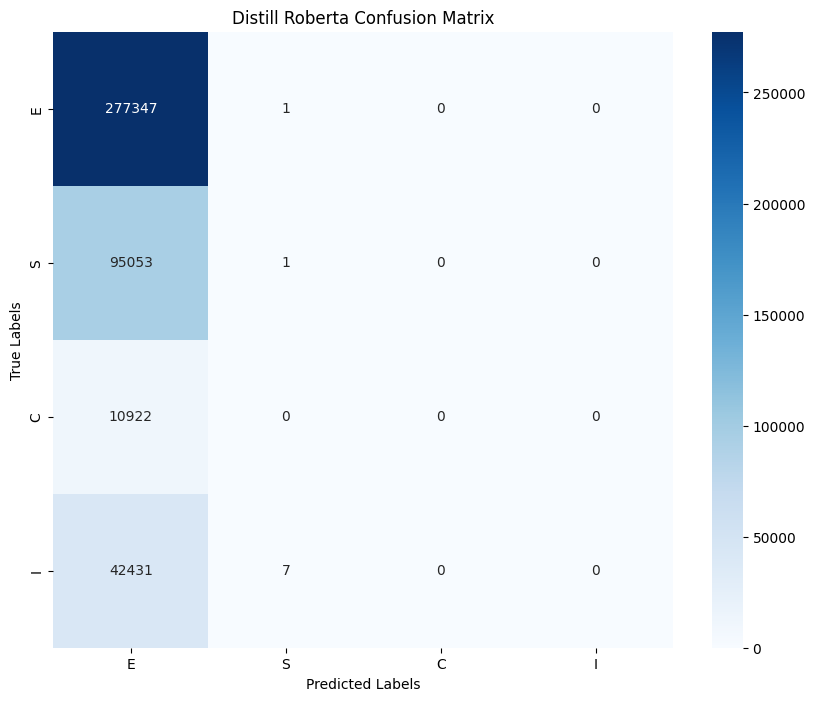

In [62]:
# make the confusion matrix
true_labels = test_df['true_label']
predicted_labels = test_df['predicted_label']

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'S', 'C', 'I'], yticklabels=['E', 'S', 'C', 'I'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Distill Roberta Confusion Matrix')
plt.show()


# Using the alldistilroberta-v1

In [15]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-distilroberta-v1')
model = AutoModel.from_pretrained('sentence-transformers/all-distilroberta-v1').to(device)

for param in model.parameters():
    param.requires_grad = False

def generate_embeddings(texts):
    batch_size = 128  # adjust this size
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

def process_partition(partition):
    query_embeddings = generate_embeddings(partition['query'])
    product_title_embeddings = generate_embeddings(partition['product_title'])

    combined = torch.cat((torch.tensor(query_embeddings), torch.tensor(product_title_embeddings)), dim=1).numpy()
    
    print(f'Combined shape: {combined.shape}')  # Expecting (n, 1536)

    result = pd.DataFrame(combined, index=partition.index, columns=[f'embedding_{i}' for i in range(combined.shape[1])])

    return result

In [16]:
# creating a data frame and enerate column names
meta = pd.DataFrame(columns=[f'embedding_{i}' for i in range(2 * 768)], dtype='float64')

# Ignore once embeddings are created 

In [15]:
# Computing the Embeddings for Train Data 
result = task_2_train.map_partitions(process_partition, meta=meta)
result = result.compute()

Combined shape: (1393063, 1536)


In [18]:
# Read it to a CSV 
result.to_csv('result_train_all-distilroberta-v1_nopunct.csv')

In [18]:
# Read it to a NUMPY 
result_array = result.to_numpy()
np.save('result_train_all-distilroberta-v1.npy', result_array)

In [16]:
# Computing the Embeddings for the Test Data
result2 = task_2_test.map_partitions(process_partition, meta=meta)
result2 = result2.compute()

Combined shape: (425762, 1536)


In [23]:
# Read it to a CSV 
result2.to_csv('result_test_all-distilroberta-v1_nopunct.csv')

In [21]:
# Read it to a NUMPY 
result2_array = result2.to_numpy()
np.save('result_test_all-distilroberta-v1.npy', result2_array)

# using the balanced dataset!

In [23]:
# computing the embeddings for the balanced data set!!
result = balanced_train.map_partitions(process_partition, meta=meta)
result = result.compute()

Combined shape: (116508, 1536)


In [24]:
result.to_csv('balanced_train.csv')

In [28]:
print(task_2_train_C.columns)
print(task_2_train_sample_E.columns)
print(task_2_train_sample_S.columns)
print(task_2_train_sample_I.columns)

Index(['example_id', 'query', 'query_id', 'product_id', 'product_locale',
       'esci_label', 'small_version', 'large_version', 'split',
       'product_title', 'product_description', 'product_bullet_point',
       'product_brand', 'product_color', 'encoded_labels'],
      dtype='object')
Index(['example_id', 'query', 'query_id', 'product_id', 'product_locale',
       'esci_label', 'small_version', 'large_version', 'split',
       'product_title', 'product_description', 'product_bullet_point',
       'product_brand', 'product_color', 'encoded_labels'],
      dtype='object')
Index(['example_id', 'query', 'query_id', 'product_id', 'product_locale',
       'esci_label', 'small_version', 'large_version', 'split',
       'product_title', 'product_description', 'product_bullet_point',
       'product_brand', 'product_color', 'encoded_labels'],
      dtype='object')
Index(['example_id', 'query', 'query_id', 'product_id', 'product_locale',
       'esci_label', 'small_version', 'large_version'

In [ ]:
result_train = result
result_test = result2

# Data loading the all-distilroberta Data

In [15]:
# read in the train and test 
result_train = pd.read_csv('balanced_train.csv', index_col=0)
result_test = pd.read_csv('result_test_all-distilroberta-v1_nopunct.csv', index_col=0)

In [17]:
# Converting from DASK to Pandas 
task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

In [18]:
# this should all be the same: pandas.core.frame.DataFrame
print(type(task_2_train))
print(type(task_2_test))
print(type(result_train))
print(type(result_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


# Establishing the MLP

In [19]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        # flatten the input 
        x = torch.flatten(x, 1) 
        x = self.fc1(x)
        x = self.relu(x)
        x = x.unsqueeze(1)
        x = self.pool(x)  
        # flatten the pooled output 
        x = x.view(x.size(0), -1) 
        # apply the 10% dropout 
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [20]:
# Inputting the Parameters

# Size of the concatenated embeddings(768 + 768)
input_size = 1536  
hidden_size = 128
# number of classes Exact, Substitute, Complement, Irrelevant (4)
num_classes = 4 

# initialize the model, loss, and optimizer
model = MLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()

# for the training hyperparameter configuration 
# Adam Optimizer with parameters: epsilon (1e-8), learning rate (5e-5) and weight decay (0.01)
optimizer = optim.Adam(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01)

# Using Softmax MLP 

In [39]:
class MLPsoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(MLPsoftmax, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(p=0.1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        pooled_output_size = hidden_size // 2
        self.fc2 = nn.Linear(pooled_output_size, num_layers)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.flatten(x, 1).float()
        # will need to download a package for F
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)

        x = self.maxpool(x)
        x = x.view(x.size(0), -1)

        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [40]:
input_size = 1536 
hidden_size = 128
num_layers = 4

model = MLPsoftmax(input_size, hidden_size, num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01)

# Labeling Indicies and Data loading

### If youre using the balcanced dataset skip to the balanced data section below 

In [41]:
task_2_train_indices = task_2_train.index.astype(int)
subset_labels = task_2_train['encoded_labels']
subset_labels = subset_labels.to_frame()

In [42]:
task_2_test_indices = task_2_test.index.astype(int)
subset_labels2 = task_2_test['encoded_labels']
subset_labels2 = subset_labels2.to_frame()

In [43]:
# not needed if not sampling 
result_train = result_train.sort_index()
result_test = result_test.sort_index()

In [34]:
class ESCIDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings.values
        # should be (size, 1563)
        print("Shape of embeddings:", self.embeddings.shape)
        self.labels = labels   

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# create DataLoader
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # adjust the batch size as needed 

Shape of embeddings: (116508, 1536)


In [45]:
# making the test loader 
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (425762, 1536)


# Getting the Probabilities of the Confusion Matrix (with the softmax)

In [46]:
def train_model_without_loss(model, train_loader, num_epochs=4):
    model.train()  # Set model to training model

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        for batch_idx, (embeddings, labels) in enumerate(train_loader):
            # Move embeddings and labels to the device
            embeddings = embeddings.to(device).float()
            
            # Forward pass to get probabilities
            outputs = model(embeddings)  # Outputs are softmax probabilities
            
            # Store or analyze the probabilities
            # For example, you can print the first batch probabilities
            if batch_idx == 0:
                print(f"Batch {batch_idx + 1} probabilities:\n{outputs[:5]}") 
                
train_model_without_loss(model, train_loader)

Epoch 1/4
Batch 1 probabilities:
tensor([[0.2266, 0.2542, 0.3227, 0.1964],
        [0.2852, 0.2350, 0.2435, 0.2363],
        [0.2804, 0.2609, 0.2242, 0.2345],
        [0.2417, 0.2878, 0.2305, 0.2400],
        [0.2695, 0.2817, 0.2374, 0.2114]], grad_fn=<SliceBackward0>)
Epoch 2/4
Batch 1 probabilities:
tensor([[0.2154, 0.2800, 0.2167, 0.2879],
        [0.2278, 0.2580, 0.2190, 0.2952],
        [0.2379, 0.2709, 0.2648, 0.2263],
        [0.2335, 0.2536, 0.2523, 0.2606],
        [0.2397, 0.2918, 0.2220, 0.2464]], grad_fn=<SliceBackward0>)
Epoch 3/4
Batch 1 probabilities:
tensor([[0.2775, 0.2583, 0.2509, 0.2133],
        [0.2529, 0.2380, 0.2439, 0.2652],
        [0.2601, 0.2624, 0.2272, 0.2503],
        [0.3138, 0.2678, 0.2095, 0.2089],
        [0.2350, 0.2640, 0.2585, 0.2425]], grad_fn=<SliceBackward0>)
Epoch 4/4
Batch 1 probabilities:
tensor([[0.2627, 0.2471, 0.2616, 0.2286],
        [0.2439, 0.2776, 0.2456, 0.2329],
        [0.3208, 0.2202, 0.2512, 0.2078],
        [0.2398, 0.2995, 0.2415

In [47]:
all_probabilities = []

for batch_idx, (embeddings, labels) in enumerate(train_loader):
    embeddings = embeddings.to(device).float()
    outputs = model(embeddings)
    all_probabilities.append(outputs.detach().cpu().numpy())  # Append to list

# Combine all probabilities into a single array
import numpy as np
all_probabilities = np.vstack(all_probabilities)

# Training and Testing 

In [29]:
# training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=4):
    model.train()  # set model to training mode
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (embeddings, labels) in enumerate(train_loader):
            embeddings, labels = embeddings.to(device), labels.to(device)

            optimizer.zero_grad()  
            outputs = model(embeddings.float()) 
            # converting the labels to long 
            labels = labels.long()
            # calculate the loss 
            loss = criterion(outputs, labels) 
            # backpropogation 
            loss.backward() 
            # updating the weights 
            optimizer.step()  

            # add up the loss 
            epoch_loss += loss.item()  

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)

Epoch 1/4, Loss: 0.8047
Epoch 2/4, Loss: 0.7897
Epoch 3/4, Loss: 0.7850
Epoch 4/4, Loss: 0.7831


In [30]:
# evaluation and output the f1 score 
def evaluate_model(test_loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # needed to change this to floats 
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # evaluate on the f1 score with micro averages
    return f1_score(all_labels, all_preds, average='micro')

In [31]:
# evaluating the model
# ran it earlier and got 0.6577
# now have 0.6562
f1 = evaluate_model(test_loader, model)
print(f'micro F1 Score: {f1:.4f}')

micro F1 Score: 0.6584


# Detecting and Looking at Mismatches

In [32]:
def evaluate_and_capture_mismatches(test_loader, model, task_2_test):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # convert task_2_test to pandas df if it's a dask df
    if hasattr(task_2_test, 'compute'):
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']].compute()
    else:
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']]

    test_df['predicted_label'] = all_preds
    test_df['true_label'] = all_labels
    
    mismatch_df = test_df[test_df['true_label'] != test_df['predicted_label']]
    
    # added test to make the confusion matrix 
    return test_df, mismatch_df

test_df, mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_141619/3143127466.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_141619/3143127466.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


In [33]:
# count top 10 mismatches per query
mismatch_counts_per_query = mismatch_df['query'].value_counts().head(10) 
mismatch_counts_per_product = mismatch_df['product_title'].value_counts().head(10)

all_text = ' '.join(mismatch_df['query'].tolist() + mismatch_df['product_title'].tolist())
word_counts = Counter(all_text.split()).most_common(10)  # Top 10 common words

print("Top 10 queries with the most mismatches:\n", mismatch_counts_per_query)
print("\nTop 10 most common words in mismatched entries:\n", word_counts)

Top 10 queries with the most mismatches:
 query
fitbit charge 3                            64
apple earbuds                              60
firestick                                  56
futon frames full size without mattress    48
airpods 2                                  47
kindle                                     46
dek pro                                    46
keep grinding hat                          42
shaggy dog board game                      42
apple earphones                            40
Name: count, dtype: int64

Top 10 most common words in mismatched entries:
 [('for', 65718), ('-', 43901), ('with', 38964), ('and', 37094), ('&', 18816), ('of', 14529), ('Black', 11477), ('|', 11407), ('without', 10341), ('2', 9396)]


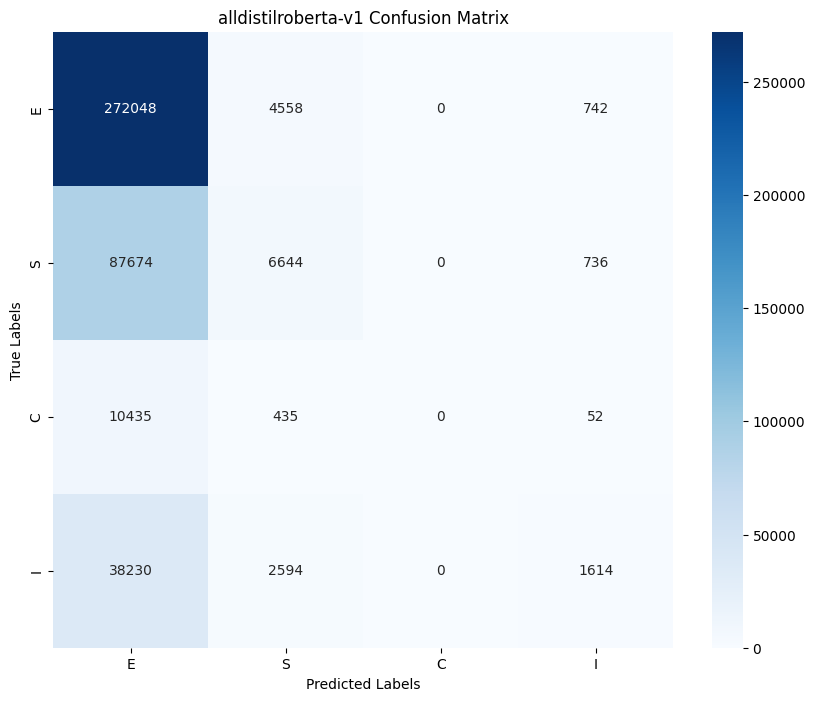

In [34]:
# make the confusion matrix
true_labels = test_df['true_label']
predicted_labels = test_df['predicted_label']

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'S', 'C', 'I'], yticklabels=['E', 'S', 'C', 'I'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('alldistilroberta-v1 Confusion Matrix')
plt.show()


# using the balanced data set for testing and training 

In [21]:
# making sure the indicies are in the same data format 
subset_indices = result_train.index
subset_indices = subset_indices.astype(int)
task_2_train_indices = task_2_train.index.astype(int)

# getting the indexes that were used in the sample group of embeddings
# maing sure they are also in the og training set 
valid_indices = task_2_train_indices[task_2_train_indices.isin(subset_indices)]

# making subset labels which filters the train dataset to get the labels the correspond to the embeddings 
subset_labels = task_2_train.loc[valid_indices, 'encoded_labels'] 
# make it into a dataframe
subset_labels = subset_labels.to_frame()

In [22]:
subset_indices2 = result_test.index
subset_indices2 = subset_indices2.astype(int)
task_2_test_indices = task_2_test.index.astype(int)

# getting the indexes that were used in the sample group of embeddings
# maing sure they are also in the og training set 
valid_indices2 = task_2_test_indices[task_2_test_indices.isin(subset_indices2)]

# making subset labels which filters the train dataset to get the labels the correspond to the embeddings 
subset_labels2 = task_2_test.loc[valid_indices2, 'encoded_labels'] 
# make it into a dataframe
subset_labels2 = subset_labels2.to_frame()

In [23]:
result_train = result_train.sort_index()
result_test = result_test.sort_index()

In [24]:
class ESCIDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings.values
        print("Shape of embeddings:", self.embeddings.shape)
        self.labels = labels   

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# create DataLoader
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # adjust the batch size as needed 

Shape of embeddings: (116508, 1536)


In [25]:
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (425762, 1536)


In [26]:
# training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=4):
    model.train()  # set model to training mode
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (embeddings, labels) in enumerate(train_loader):
            embeddings, labels = embeddings.to(device), labels.to(device)

            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(embeddings.float())  # Forward pass
            # converting the labels to long in order to 
            labels = labels.long()
            # calculate the loss 
            loss = criterion(outputs, labels) 
            # backpropogation 
            loss.backward() 
            # updating the weights 
            optimizer.step()  

            # add up the loss 
            epoch_loss += loss.item()  

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)

Epoch 1/4, Loss: 1.2577
Epoch 2/4, Loss: 1.2085
Epoch 3/4, Loss: 1.1882
Epoch 4/4, Loss: 1.1723


In [27]:
# evaluation and output the f1 score 
def evaluate_model(test_loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # needed to change this to floats 
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # evaluate on the f1 score with micro averages
    return f1_score(all_labels, all_preds, average='micro')

In [28]:
f1 = evaluate_model(test_loader, model)
print(f'micro F1 Score: {f1:.4f}')

micro F1 Score: 0.4067


In [29]:
def evaluate_and_capture_mismatches(test_loader, model, task_2_test):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # convert task_2_test to pandas df if it's a dask df
    if hasattr(task_2_test, 'compute'):
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']].compute()
    else:
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']]

    test_df['predicted_label'] = all_preds
    test_df['true_label'] = all_labels
    
    mismatch_df = test_df[test_df['true_label'] != test_df['predicted_label']]
    
    # added test to make the confusion matrix 
    return test_df, mismatch_df

test_df, mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_19599/3143127466.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_19599/3143127466.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


In [30]:
mismatch_counts_per_query = mismatch_df['query'].value_counts().head(10) 
mismatch_counts_per_product = mismatch_df['product_title'].value_counts().head(10)

all_text = ' '.join(mismatch_df['query'].tolist() + mismatch_df['product_title'].tolist())
word_counts = Counter(all_text.split()).most_common(10)  # Top 10 common words

print("Top 10 queries with the most mismatches:\n", mismatch_counts_per_query)
print("\nTop 10 most common words in mismatched entries:\n", word_counts)

Top 10 queries with the most mismatches:
 query
cap toe brown shoes                  68
yeti                                 64
macbook air                          62
nintendo switch                      62
apple earbuds                        60
fire pit                             60
apple earphones                      59
iphone headphones                    58
smart watch                          58
outdoor ceiling fan without light    58
Name: count, dtype: int64

Top 10 most common words in mismatched entries:
 [('for', 110177), ('-', 75220), ('with', 63692), ('and', 59625), ('&', 29716), ('of', 23891), ('Black', 19986), ('|', 18287), ('2', 17181), ('to', 15232)]


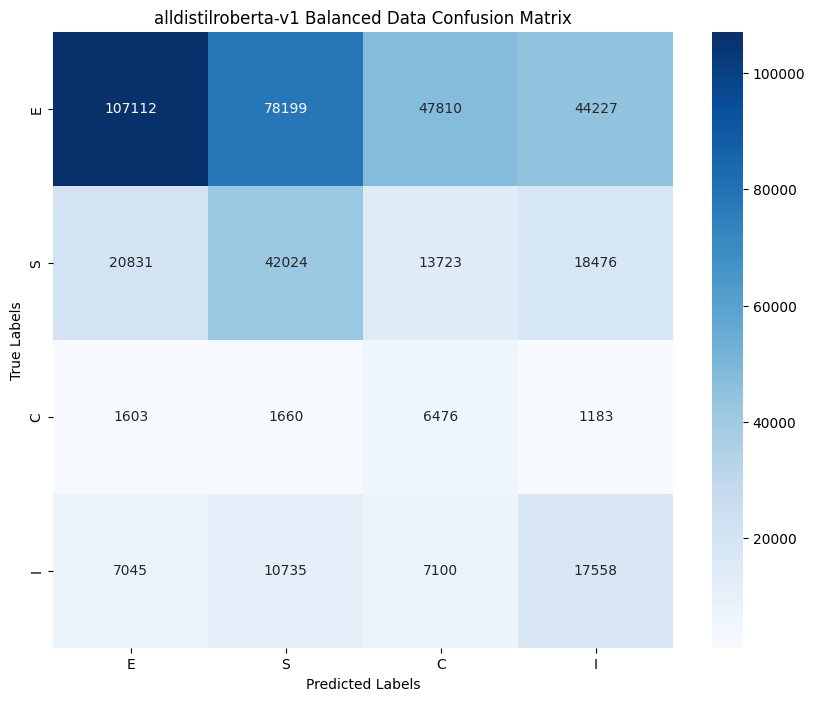

In [32]:
true_labels = test_df['true_label']
predicted_labels = test_df['predicted_label']

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'S', 'C', 'I'], yticklabels=['E', 'S', 'C', 'I'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('alldistilroberta-v1 Balanced Data Confusion Matrix')
plt.show()
